Grin Case Study===========

In [34]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2
import seaborn as sns

### Connecting to Grin Challenge Database


In [2]:
def get_from_sql(query):
    conn = psycopg2.connect(user='grin_technical_challenge',
                               host='grin-technical-test.crf3v8rvj0hp.us-east-1.rds.amazonaws.com',
                               database='postgres',
                               port='5432',
                               password='kjbaskc24bkjhb354bbjk')
    df = pd.read_sql(query, conn)
    return df

### Retrieving rides data


In [3]:
query = '''
select * from rides
'''


df = get_from_sql(query)

### Calculating the RFM Matrix (Recency, Frequency, Monetary)

* Recency (R): Who have purchased recently? Number of days since last purchase (least recency)
* Frequency (F): Who has purchased frequently? It means the total number of purchases. (high frequency)
* Monetary Value(M): Who have high purchase amount? It means the total money customer spent (high monetary value)

Here, each of the three variables (Recency, Frequency, and Monetary) consists of four equal groups, which creates 64 (4x4x4) different customer segments.

In [93]:
rfm = df.groupby('user_id').agg({'finish_time': max,
                                 'price': sum,
                                 'id': 'count'})\
                            .rename(columns={'finish_time': 'last_ride', 'price': 'monetary', 'id': 'frequency'})

rfm['last_ride'] = rfm['last_ride'].dt.date

# Normally we would consider the current date as today, but since we only have data until Sep. 17th, \
# let's pretend the 18th is our current date
rfm['recency'] = datetime.date(2018, 9, 18) - rfm['last_ride']
rfm = rfm.drop('last_ride', axis=1)

rfm.head()

,monetary,frequency,recency
user_id,,,
1.0,295.42,14,1 days
2.0,138.35,10,3 days
3.0,36.79,2,7 days
4.0,13.70,1,8 days
5.0,202.04,11,19 days


### Computing Quantile of RFM values

Customers with the lowest recency, highest frequency and monetary amounts considered as top customers.

qcut() is Quantile-based discretization function. qcut bins the data based on sample quantiles. For example, 1000 values for 4 quantiles would produce a categorical object indicating quantile membership for each customer.



In [94]:
rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, labels=[4, 3, 2, 1], duplicates='drop') #Recency is inverted because the most recent has a higher value
rfm['f_quartile'] = pd.qcut(rfm['frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['m_quartile'] = pd.qcut(rfm['monetary'], 4, labels=[1, 2, 3, 4])

rfm.head()

,monetary,frequency,recency,r_quartile,f_quartile,m_quartile
user_id,,,,,,
1.0,295.42,14,1 days,4,4,4
2.0,138.35,10,3 days,4,4,4
3.0,36.79,2,7 days,3,2,3
4.0,13.70,1,8 days,3,1,1
5.0,202.04,11,19 days,2,4,4


### RFM Result Interpretation

Combining all three quartiles(r_quartile,f_quartile,m_quartile) in a single column will help giving interpretability.

In [95]:
rfm['RFM_Segment'] = rfm.r_quartile.astype(str)+ rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)
rfm['RFM_Score'] = rfm[['r_quartile', 'f_quartile', 'm_quartile']].sum(axis=1)

rfm.head()

,monetary,frequency,recency,r_quartile,f_quartile,m_quartile,RFM_Segment,RFM_Score
user_id,,,,,,,,
1.0,295.42,14,1 days,4,4,4,444,12.0
2.0,138.35,10,3 days,4,4,4,444,12.0
3.0,36.79,2,7 days,3,2,3,323,8.0
4.0,13.70,1,8 days,3,1,1,311,5.0
5.0,202.04,11,19 days,2,4,4,244,10.0


### Pick your champion!

Let's assume you want to see your most recent rider, most frequent and most lifetime-value.

In this case, you'd want to filter out the group **444** on the RFM_Segment column or **12** on the RFM_Score column. So, let's do that.

Recency 4 = Most Recent

Frequency 4 = Most Frequent

Frequency 4 = Most Lifetime value

In [96]:
champions = rfm[rfm['RFM_Segment'] == '444'].sort_values('monetary', ascending=False)
champions.head(10) #Top 10

,monetary,frequency,recency,r_quartile,f_quartile,m_quartile,RFM_Segment,RFM_Score
user_id,,,,,,,,
1110759.0,4897.41,519,1 days,4,4,4,444,12.0
637970.0,2174.34,83,1 days,4,4,4,444,12.0
701742.0,1509.74,69,2 days,4,4,4,444,12.0
33289.0,1210.38,46,5 days,4,4,4,444,12.0
126006.0,1072.50,45,2 days,4,4,4,444,12.0
122079.0,1063.66,83,2 days,4,4,4,444,12.0
258951.0,1057.11,56,3 days,4,4,4,444,12.0
1075277.0,1053.48,78,2 days,4,4,4,444,12.0
1128626.0,1050.01,61,2 days,4,4,4,444,12.0


### Investigating the size of each RFM Segment


In [97]:
rfm.groupby('RFM_Segment').size().sort_values(ascending=False)[:10]

RFM_Segment
444    79018
111    46964
344    46866
121    29424
211    28802
112    28724
333    25869
233    24984
244    22788
221    22650
dtype: int64

### Summary metrics for each RFM Segment

In [98]:
rfm['recency'] = rfm['recency'].dt.days

rfm.groupby('RFM_Segment').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count'] }).round(1)

recency frequency monetary       
             mean      mean     mean  count
RFM_Score                                  
3.0          41.3       1.0      9.1  46964
4.0          33.2       1.0     12.4  86950
5.0          25.0       1.1     16.7  93053
6.0          19.5       1.4     19.7  98541
7.0          16.6       1.8     25.4  92247
8.0          14.5       2.4     34.2  80616
9.0          11.8       3.2     44.7  77506
10.0         10.2       4.7     66.1  72515
11.0          6.8       7.1     95.9  72564
12.0          3.0      10.9    142.1  79018

### Grouping segments

Next, we could create business rules to fit these RFM Segments into categories, such as Bronze, Silver, Gold, etc...

Or we could try another approach: let the machine figure it out for us.

For that, we will use *k-means clustering*, a unsupervised machine learning technique.

### Checking for skewness in the variables

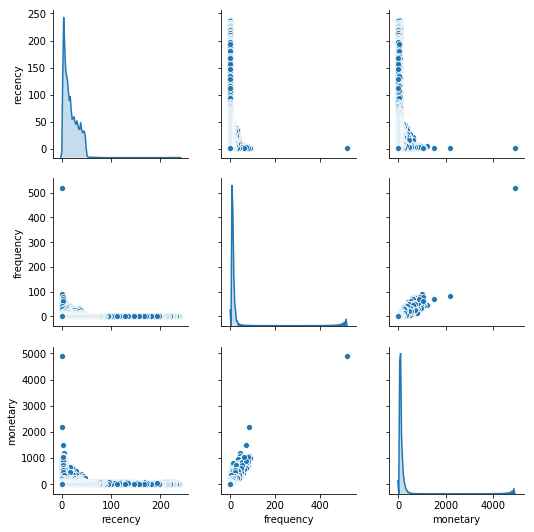

In [104]:
sns.pairplot(rfm[['recency', 'frequency', 'monetary']], diag_kind='kde')

### Managing the skewness

As we can see on the plot above, it is clear that the 3 variables are skewed.

#### Sequence
* Unskew the data - log transformation
* Standardize to the same average values
* Scale to the same standard deviation
* Store as a separate array to be used for clustering

In [156]:
from sklearn.preprocessing import StandardScaler


rfm_log = np.log(rfm[['recency', 'frequency', 'monetary']] + 1)

scaler = StandardScaler()
scaler.fit(rfm_log[['recency', 'frequency', 'monetary']])

rfm_normalized = scaler.transform(rfm_log[['recency', 'frequency', 'monetary']])

print('mean: ', rfm_normalized.mean(axis=0).round(2))
print('std: ', rfm_normalized.std(axis=0).round(2))

mean:  [-0.  0. -0.]
std:  [1. 1. 1.]


### K-means Clustering

* <strike>Data pre-processing</strike>
* Choosing a number of clusters
* Running k-means clustering on pre-processed data
* Analyzing average RFM values of each cluster

In [158]:
from sklearn.cluster import KMeans

#let's try with a 4-clusters solution first:
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(rfm_normalized)

cluster_labels = kmeans.labels_

In [164]:
rfm_w_clusters = rfm.assign(cluster = cluster_labels + 1) #Adding 1 so we don't end up with a Cluster 0


rfm_w_clusters.groupby(['cluster']).agg({
                                        'recency': 'mean',
                                        'frequency': 'mean',
                                        'monetary': ['mean', 'count'],
                                        }).round(0)

recency frequency monetary        
           mean      mean     mean   count
cluster                                   
1           5.0       2.0     22.0  171578
2           5.0      10.0    127.0  145482
3          19.0       3.0     51.0  190634
4          30.0       1.0     15.0  292280

### Choosing the number of clusters

We can infer the optimal number of cluster by utilizing the elbow plot

In [166]:
# Fit KMeans and calculate Sum of Squared Errors for each *k*
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(rfm_normalized)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center

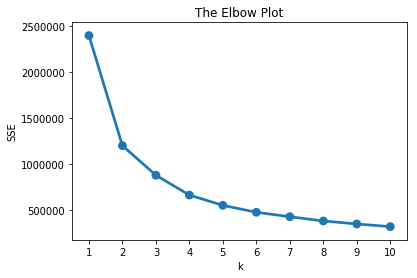

In [167]:
#Plotting
plt.title('The Elbow Plot')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

#### So... 4 Clusters?

There's no correct answer to this. But this plot helps visualizing the optimal number of clusters (where the error is minimized and we can still maintain a level of clustering to our data). For this challenge I am choosing 4 clusters, backed by data. But it could work for 3 clusters too, depending on the level of resolution one might want.

### Creating a snake plot to interpret each cluster

In [175]:
rfm_normalized_df = pd.DataFrame(rfm_normalized, 
                                   index=rfm.index, 
                                   columns=['recency', 'frequency', 'monetary'])
rfm_normalized_df['cluster'] = rfm_w_clusters['cluster']


rfm_normalized_df.head()

,recency,frequency,monetary,cluster
user_id,,,,
1.0,-2.121185,2.383242,2.516623,2
2.0,-1.341462,1.881421,1.689942,2
3.0,-0.561738,-0.220779,0.260705,1
4.0,-0.429243,-0.876809,-0.773425,1
5.0,0.469001,2.022202,2.102209,2


In [178]:
rfm_melt = pd.melt(rfm_normalized_df.reset_index(), 
                    id_vars=['user_id', 'cluster'],
                    value_vars=['recency', 'frequency', 'monetary'], 
                    var_name='attribute', 
                    value_name='value')

rfm_melt.head()

,user_id,cluster,attribute,value
0,1.0,2,recency,-2.121185
1,2.0,2,recency,-1.341462
2,3.0,1,recency,-0.561738
3,4.0,1,recency,-0.429243
4,5.0,2,recency,0.469001


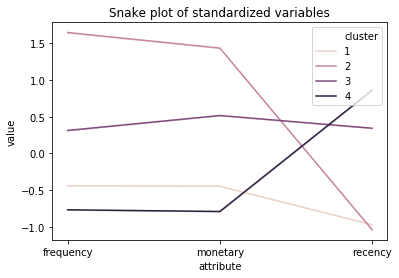

In [179]:
#Snake Plot

plt.title('Snake plot of standardized variables')
sns.lineplot(x="attribute", y="value", hue='cluster', data=rfm_melt)

### Relative importance of segment attributes

In [185]:
cluster_avg = rfm_w_clusters.groupby(['cluster']).mean()
population_avg = rfm[['recency', 'frequency', 'monetary']].mean()

relative_importance = cluster_avg / population_avg - 1

In [192]:
relative_importance = relative_importance[['recency', 'frequency', 'monetary']]

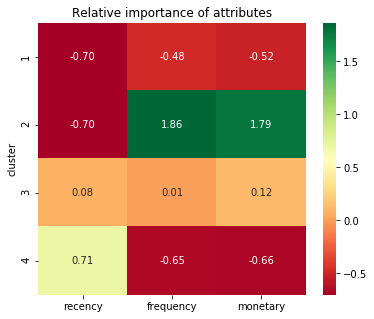

In [198]:
plt.figure(figsize=(6, 5))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_importance, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()